# T3 - Multiple populations

In this tutorial, we will examine how to work with simulations that have more than one population. At the simplest level, multiple populations simply involve instantiating multiple copies of the framework's compartment structure. Of course, much of the value of having multiple populations comes from them being able to affect each other, leading to different epidemic dynamics. There are two ways in which populations can affect each other in Atomica

- _Transfers_ which involve people moving from one population to another
- _Interactions_ which involve parameter values being computed across multiple populations

Transfers are defined entirely within the databook, while interactions need to first be defined in the framework. We will start with transfers, and then look at interactions. 

## Transfers

A transfers involves moving people from one population to another. When this movement takes place, the compartments they are in are preserved. Effectively, a simulation with multiple populations can be considered a single, large network of compartments, with duplicate compartment names across populations, and transfers being links that connect those compartments. Defining a transfer in a databook then corresponds to setting a transfer rate between all corresponding compartments in the selected populations, as shown below.

![transfer-1](assets/T3/t3.png)

In order to define a transfer, we need to create one in the databook. This can be done at the same time as creating the databook - for example:

In [1]:
import atomica as at
F = at.ProjectFramework('assets/T3/t3_framework_1.xlsx')
D = at.ProjectData.new(framework=F,tvec=[2016,2017],pops=1,transfers=1)

As discussed in Tutorial 1, it is also possible to programatically edit existing databooks (at the expense of losing comments). This provides a pathway to perform operations like adding populations and transfers without losing all of the previously entered values in the databook. To do this, first load the data into a `ProjectData` object, then use `ProjectData` methods to modify the `ProjectData`, and then save it back. For example:

In [2]:
D = at.ProjectData.from_spreadsheet('assets/T3/t3_databook_1.xlsx',framework=F)
D.add_pop('pris','Prisoners')
D.add_transfer('inc','Incarceration')
D.save('t3_temp.xlsx')

Object saved to /home/vsts/work/1/s/docs/tutorial/t3_temp.xlsx.


If we look at the 'Flows' sheet of the databook, we can see how the existing values in the 'adults' population have been preserved (including the extra value in 2018), and we can see that each table now has an extra row for the prisoner population. Notice however, that also that all of the extra content has been removed

![transfer-db-1](assets/T3/transfer_db_1.png)

We will add in the same values for the prisoner population as the adult population, except

- The compartments will be initialized with 0 people, so that we can see the transfer clearly
- The birth rate in the prisoner population will be 0

We focus now on the 'Transfers' sheet. 

![transfer-db-2](assets/T3/transfer_db_2.png)

In the databook, a transfer is defined by three tables. The top table specifies the name of the transfer (the population type can be ignored for now). The middle table defines which transfers exist. And then the bottom table specifies the values for those transfers.

In this case, we want to have an 'incarceration' transfer that moves adults into the prisoner population. Therefore, we need to specify that a transfer from 'adults' to 'pris' exists. In the middle table, transfers go from row to column. So we set the value of cell C5 to 'Y' to indicate that we want to have this transfer.

![transfer-db-3](assets/T3/transfer_db_3.png)

Upon changing the cell to 'Y', a data entry row in the bottom table becomes active. The row clearly indicates `adults ---> pris` to confirm the direction of the transfer. The values in the row can then be entered in exactly the same way as the values on the parameters table. Note that the units for the transfer can be 'Probability (per year)' or 'Number (per year)' and they can be set in the databook itself (whereas for parameters, the units are declared in the framework and they cannot be changed in the databook). 

For this transfer, we will enter that a total of 100 people per year are incarcerated. 

![databook-4](assets/T3/transfer_db_4.png)

Now we can create a project and run a simulation in exactly the same way as before. The databook for this example is available in the Atomica repository under `atomica/docs/tutorial/assets/T3/t3_databook_2.xlsx`. 

In [3]:
P = at.Project(framework=F,databook='assets/T3/t3_databook_2.xlsx')

Elapsed time for running "default": 0.0171s


If we plot the results, we we can now see how the population in the prisoner population increases each year: 

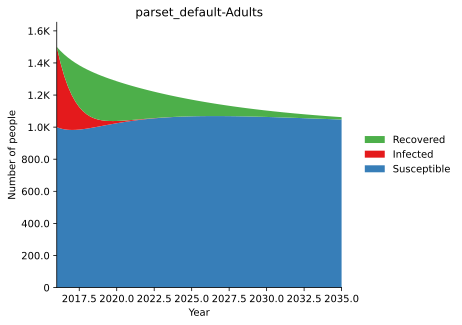

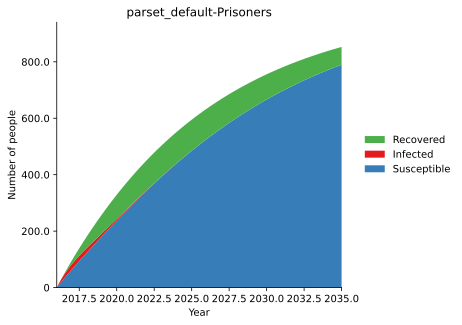

In [4]:
d = at.PlotData(P.results[0],project=P)
at.plot_series(d,plot_type='stacked');

We can also plot the flow rate from 'adults' to 'prisoners' of 100 people per year, disaggregating the compartments that people are being transferred from. As expected, because the prevalence is dropping over time, more and more of the 100 people being incarcerated are coming from the 'susceptible' compartment. The `outputs` argument in the command below follows a standard syntax for accessing flow rates in Atomica (`source_name:dest_name:par_name`) - for more details, see the code documentation. 

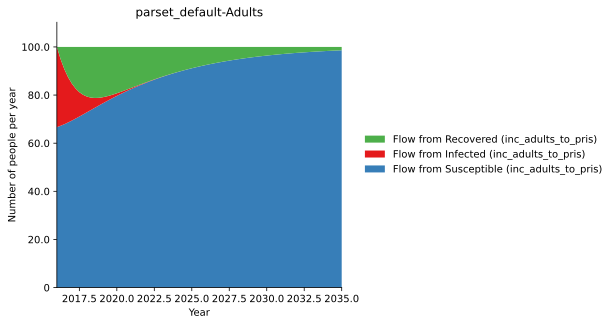

In [5]:
d = at.PlotData(P.results[0],outputs=['sus::inc_adults_to_pris','inf::inc_adults_to_pris','rec::inc_adults_to_pris'],pops='adults',project=P)
at.plot_series(d,plot_type='stacked');

## Interactions

The second way that populations can affect each other is via parameters. Because we are working with parameters, this takes place primarily in the framework, so it is independent of the populations that actually end up being instantiated. Cross-population parameters are implemented by either summing or averaging parameters across populations, using the special functions `SRC_POP_SUM` and `SRC_POP_AVG`. In this case, we have a certain prevalence and infectiousness in each population, leading to a force of infection within each population. However, we want to account for the fact that the total force of infection depends on the prevalance in other populations as well. The net force of infection can be expressed as a weighted average of the force of infection in all populations, with different weights in every population.

To implement this, we will first set up the force of infection as an unweighted average, and then introduce weights. We start by splitting the `foi` parameter into two parameters - `foi_out` which is the force of infection computed within each population only, and `foi_in`, which is the force of infection taking into account cross-population interactions. This naming reflects the idea that `foi_out` reflects 'outgoing' disease from the population, while `foi_in` reflects the aggregation of infectiousness driving 'incoming' disease in the population. 

![interaction-1](assets/T3/interaction_1.png)

We also need to change the 'Transitions' sheet to use `foi_in` instead of `foi` to drive the transition from `sus` to `inf`. We can go ahead and run a simulation with this framework. Note that we didn't change anything in the framework that would result in changes to the databook compared to our previous example. Therefore, we can create a project using the new framework but with the databook from the previous example. The modified framework is available in the Atomica repository under `atomica/docs/tutorial/assets/T3/t3_framework_2.xlsx`. 

In [6]:
P = at.Project(framework='assets/T3/t3_framework_2.xlsx',databook='assets/T3/t3_databook_2.xlsx')
result = P.results[0]

Elapsed time for running "default": 0.0197s


Now, we want to see how the value of `foi_in` in each population relates to the value of `foi_out`. First, check `foi_in` in each population

In [7]:
v1 = result.get_variable('foi_out')
print('foi_out (adults): %.4f' % (v1[0].vals[1]))
print('foi_out (pris): %.4f' % (v1[1].vals[1]))
print('Expected value of foi_in = %.4f' % ((v1[0].vals[1]+v1[1].vals[1])/2))
v2 = result.get_variable('foi_in')
print('foi_in (adults): %.4f' % (v2[0].vals[1]))
print('foi_in (pris): %.4f' % (v2[1].vals[1]))
assert abs(((v1[0].vals[1]+v1[1].vals[1])/2)-v2[0].vals[1])<1e-4  # Check that the values are correct
assert abs(v2[0].vals[1]-v2[0].vals[1])<1e-6  # Check that the values are correct

foi_out (adults): 0.0542
foi_out (pris): 0.0667
Expected value of foi_in = 0.0605
foi_in (adults): 0.0605
foi_in (pris): 0.0605


So we can see how the `SRC_POP_AVG` function has taken the unweighted average of `foi_out` and used it in both populations. However, we would typically want this interaction to be weighted in two ways

- By the number of interacting people
- By an interaction weight specific to the populations

For example, consider an example of children interacting with prisoners

- The infectiousness parameter in the 'child' population might be larger than in the 'prisoner' population because children are less likely to wash their hands
- The number of prison infections caused by children increases if there are more children
- Most prisoners don't come in contact with children in the general population, so only a small proportion of the force of infection in the prisoner population comes from children

Weighting by the the number of people accounts for the second factor above, while an interaction-specific weight (representing the probability of interactions/contact between the populations) accounts for the third factor above.

Interaction weights need to appear in the parameter function, so their existence must be declared in the framework file. But the interaction weights need to be entered in the databook, so they also need to be entered there. We can add the interaction to the framework by adding an entry on the 'Interactions' sheet, with a default value of `1`. 

![interaction-2](assets/T3/interaction_2.png)

We can then add this interaction as the second argument to `SRC_POP_AVG` on the 'Parameters' sheet

![interaction-3](assets/T3/interaction_3.png)

Finally, we need to add this interaction to the databook. If we create a new databook using the modified framework, this would happen automatically. However, here we will add the interaction to the existing databook from the previous example, to avoid having to re-enter all of the other data values. Note that when we do this, we need to make sure that the code name and full name of the interaction being added to the databook exactly matches the names that were entered in the framework.

In [8]:
D = at.ProjectData.from_spreadsheet('assets/T3/t3_databook_2.xlsx',framework=F)
D.add_interaction('contacts','Contacts')
D.save('t3_temp_2.xlsx')

Object saved to /home/vsts/work/1/s/docs/tutorial/t3_temp_2.xlsx.


If we open the databook, we now see that there is an 'Interactions' sheet. The format is very similar to transfers, with three tables

- A table to name the interaction
- A matrix of interactions. Unlike transfers, entries may be placed on the diagonal as well
- Rows representing directional interactions the same as transfers, but with undefined units for the data

![interaction-4](assets/T3/interaction_4.png)

Ordinarily, with the default value of `1` specified in the framework, all of the interactions would be present ('Y' in each matrix entry) and pre-filled with a value of `1`. This didn't happen because we added the interaction manually, so we can just make that change by hand.

![interaction-5](assets/T3/interaction_5.png)

Because all of the weights are `1`, this just corresponds to an unweighted average, and indeed if we use the same test case as before, we see the same results:

In [9]:
P = at.Project(framework='assets/T3/t3_framework_3.xlsx',databook='assets/T3/t3_databook_3.xlsx')
result = P.results[0]
v1 = result.get_variable('foi_out')
print('foi_out (adults): %.4f' % (v1[0].vals[1]))
print('foi_out (pris): %.4f' % (v1[1].vals[1]))
print('Expected value of foi_in = %.4f' % ((v1[0].vals[1]+v1[1].vals[1])/2))
v2 = result.get_variable('foi_in')
print('foi_in (adults): %.4f' % (v2[0].vals[1]))
print('foi_in (pris): %.4f' % (v2[1].vals[1]))
assert abs(((v1[0].vals[1]+v1[1].vals[1])/2)-v2[0].vals[1])<1e-4  # Check that the values are correct
assert abs(v2[0].vals[1]-v2[0].vals[1])<1e-4  # Check that the values are correct

Elapsed time for running "default": 0.0235s


foi_out (adults): 0.0542
foi_out (pris): 0.0667
Expected value of foi_in = 0.0605
foi_in (adults): 0.0605
foi_in (pris): 0.0605


However, now consider the case where the `prisoner-prisoner` interaction has a value of `2`. 

![interaction-6](assets/T3/interaction_6.png)

This is effectively saying that prisoners interact with each other twice as frequently as they interact with adults in the general population, and thus the force of infection in the prisoner population depends more on the prevalence within the prisoner population than the general population.

<div class="alert alert-block alert-info">
Interactions are normalized so that the interaction weights all add to 1.0. Thus only the relative values matter, whether the values were `1:2` or `2:4` would make no difference
</div>


In [10]:
P = at.Project(framework='assets/T3/t3_framework_3.xlsx',databook='assets/T3/t3_databook_4.xlsx')
result = P.results[0]
v1 = result.get_variable('foi_out')
print('foi_out (adults): %.4f' % (v1[0].vals[1]))
print('foi_out (pris): %.4f' % (v1[1].vals[1]))
print('Expected value of foi_in for prisoners = %.4f' % ((v1[0].vals[1]+2*v1[1].vals[1])/3))
v2 = result.get_variable('foi_in')
print('foi_in (adults): %.4f' % (v2[0].vals[1]))
print('foi_in (pris): %.4f' % (v2[1].vals[1]))
assert abs(((v1[0].vals[1]+2*v1[1].vals[1])/3)-v2[1].vals[1])<1e-6  # Check that the values are correct

Elapsed time for running "default": 0.0241s


foi_out (adults): 0.0542
foi_out (pris): 0.0667
Expected value of foi_in for prisoners = 0.0625
foi_in (adults): 0.0605
foi_in (pris): 0.0625


So we can see how the interaction weights fed into the weighted average done by `SRC_POP_AVG`. The final common weighting factor is by population size. In Atomica, this is generalized to any variable within the population, which could be the population size, or it could be the size of some target compartments, or simply an arbitrary weighting factor provided by the user or calculated using a parameter function. In this case, we will weight the interaction by the population size. 

In order to do this, we need to first define a quantity in the framework that represents the population size. We will make a parameter in this example, but normally this would be done using characteristics (discussed further in the next tutorial). 

![interaction-7](assets/T3/interaction_7.png)


Then, we add the new `popsize` variable as the third argument to `SRC_POP_AVG`. As before, this framework change doesn't need any change in the databook, so we can immediately run the model with the modified framework

In [11]:
P = at.Project(framework='assets/T3/t3_framework_4.xlsx',databook='assets/T3/t3_databook_4.xlsx')
result = P.results[0]

Elapsed time for running "default": 0.0227s


This time, the calculation to verify the weighted average is a little more involved, because we need to get the population size variable as well

In [12]:
foi_out = result.get_variable('foi_out')
popsize = result.get_variable('popsize')
foi_in = result.get_variable('foi_in')
print('popsize (adults): %.4f' % (popsize[0].vals[1]))
print('popsize (prisoners): %.4f' % (popsize[1].vals[1]))
adult_weight = 1*popsize[0].vals[1]
pris_weight = 2*popsize[1].vals[1]
avg = (adult_weight*foi_out[0].vals[1]+pris_weight*foi_out[1].vals[1])/(adult_weight+pris_weight)
print('Expected prisoner foi_in: %.4f' % (avg))
print('Actual prisoner foi_in: %.4f' % (foi_in[1].vals[1]))
assert abs(avg-foi_in[1].vals[1])<1e-6  # Check that the values are correct

popsize (adults): 1475.0000
popsize (prisoners): 25.0000
Expected prisoner foi_in: 0.0557
Actual prisoner foi_in: 0.0557


Finally, along with `SRC_POP_SUM` and `SRC_POP_AVG` there are complementary functions `TGT_POP_SUM` and `TGT_POP_AVG`. The `TGT_POP_*` functions differe from `SRC_POP_*` by transposing the interaction weight matrix, effectively reversing the directionality. This is typically only required in special circumstances and is not widely used. 

## Exercises

- Using the SIR model from the first tutorial (single population SIR), set up 3 populations for ages 0-14, 15-64, and 65+. Think carefully about what the value of the transfer should be (hint: it will be in probability units, and depend on the age range of each population)
- Using the SIR from the first tutorial, set up 2 populations for FSW and clients. No transfers are required. Change the force of infection so that it depends on an interaction, weighted by the number of infected FSW and clients, such that there is transmission between FSW and clients, but no transmission within either population